# AdaBoost Implementation
Consider the toy data set on which I have applied AdaBoost with the following settings: Number of iterations M=10, 
weak classifier = Decision Tree of depth 1 and 2 leaf nodes


In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
sns.set_style('white')

from sklearn.tree import DecisionTreeClassifier

In [2]:
#Toy Dataset
x1 = np.array([.1,.2,.4,.8, .8, .05,.08,.12,.33,.55,.66,.77,.88,.2,.3,.4,.5,.6,.25,.3,.5,.7,.6])
x2 = np.array([.2,.65,.7,.6, .3,.1,.4,.66,.77,.65,.68,.55,.44,.1,.3,.4,.3,.15,.15,.5,.55,.2,.4])
y = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
X = np.vstack((x1,x2)).T

def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    
    #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    else :
        zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

In [3]:
#creating own adaboost library from sratch
def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

In [4]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=10, learning_rate = 1)

Accuracy =  1.0


In [5]:
def plot_AdaBoost_scratch_boundary(estimators,estimator_weights, X, y, N = 10,ax = None ):
    
    def AdaBoost_scratch_classify(x_temp, est,est_weights ):
        '''Return classification prediction for a given point X and a previously fitted AdaBoost'''
        temp_pred = np.asarray( [ (e.predict(x_temp)).T* w for e, w in zip(est,est_weights )]  ) / est_weights.sum()
        return np.sign(temp_pred.sum(axis = 0))
    
    
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))


    zz = np.array( [AdaBoost_scratch_classify(np.array([xi,yi]).reshape(1,-1), estimators,estimator_weights ) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

# Plotting resulting decision boundary

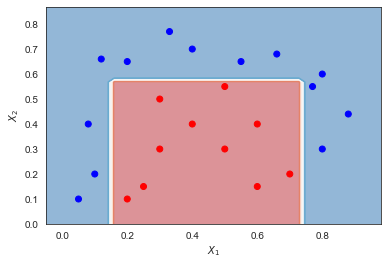

In [6]:
#Consider the toy data set on which I have applied AdaBoost with the following settings:
#Number of iterations M=10, weak classifier = Decision Tree of depth 1 and 2 leaf nodes
#The boundary between red and blue data points is clearly non linear, yet the algorithm does pretty well
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )

# Viewing decision boundaries of the weak classifiers inside AdaBoost
Visualizing the sequence of weak learners and the sample weights
M=10 iterations
Size of scatter points is proportional to scale of sample_weights

For example, in the top left plot m=0, 6 blue points are misclassified. In the next ieration m=1,
their sample weight is increased and the scatter plot shows them as bigger.

Accuracy =  1.0


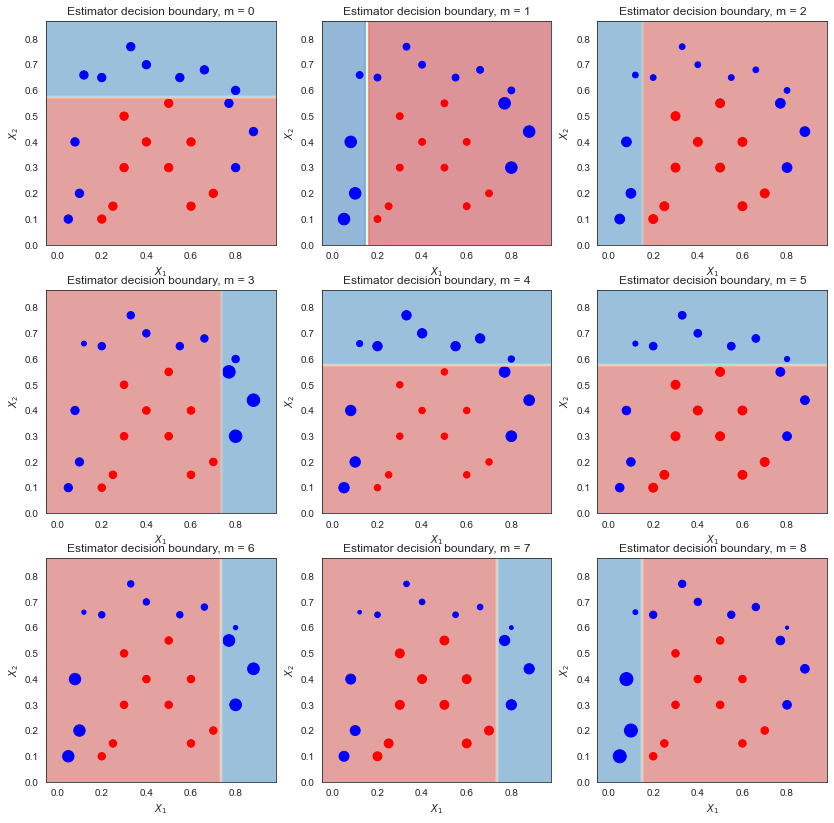

In [7]:
#The first 6 weak learners m=1,2...,6 are shown below. The scatter points are scaled 
#sample weight at each iteration according to their respective 
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=10, learning_rate = 1)

fig = plt.figure(figsize = (14,14))
for m in range(0,9):
    fig.add_subplot(3,3,m+1)
    s_weights = (sample_weight_list[m,:] / sample_weight_list[m,:].sum() ) * 40
    plot_decision_boundary(estimator_list[m], X,y,N = 50, scatter_weights =s_weights )
    plt.title('Estimator decision boundary, m = {}'.format(m))

Accuracy =  0.7391304347826086
[0.10414539 0.09373085 0.08435776 0.07592199 0.06832979 0.06149681
 0.05534713 0.0549876  0.05308348 0.05268687]
Accuracy =  0.8695652173913043
[0.52072694 0.26823221 0.34353197 0.2425222  0.31806477 0.3092209
 0.31967048 0.29344342 0.25530824 0.30996101]
Accuracy =  1.0
[1.04145387 0.87546874 0.83739679 0.78053386 1.03993142 0.93832294
 0.62863165 0.8769354  0.77916076 1.05526061]
Accuracy =  0.7391304347826086
[1.04145387]
Accuracy =  0.8695652173913043
[1.04145387 0.87546874 0.83739679]
Accuracy =  1.0
[1.04145387 0.87546874 0.83739679 0.78053386 1.03993142 0.93832294
 0.62863165 0.8769354  0.77916076 1.05526061]


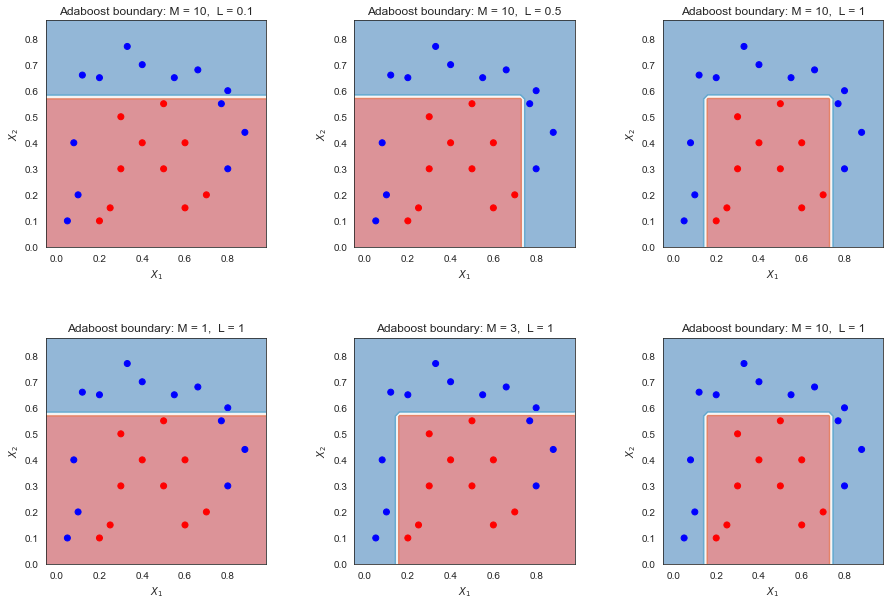

In [8]:
#processing explained below in comments
'''
First iteration:

The decision boundary is very simple (linear) since these are wea learners
All points are of the same size, as expected
6 blue points are in the red region and are misclassified
Second iteration:

The linear decision boundary has changed
The previously misclassified blue points are now larger (greater sample_weight) and have influenced the decision boundary
9 blue points are now misclassified
Final result after 10 iterations

All classifiers have a linear decision boundary, at different positions. The resulting coefficients of the first 6 iterations αm are :

([1.041, 0.875, 0.837, 0.781, 1.04 , 0.938...

As expected, the first iteration has largest coefficient as it is the one with the fewest mis-classifications
'''
fig = plt.figure(figsize = (15,10))
for k,l in enumerate([0.1,0.5,1]):
    fig.add_subplot(2,3,k+1)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    estimator_list, estimator_weight_list, sample_weight_list = AdaBoost_scratch(X,y, M=10, learning_rate = l)
    plot_AdaBoost_scratch_boundary(estimator_list,estimator_weight_list, X, y, N = 50,ax = None )
    plt.title('Adaboost boundary: M = 10,  L = {}'.format(l))
    print(estimator_weight_list)

for k,m in enumerate([1,3,10]):
    fig.add_subplot(2,3,k+4)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    estimator_list, estimator_weight_list, sample_weight_list = AdaBoost_scratch(X,y, M=m, learning_rate = 1)
    plot_AdaBoost_scratch_boundary(estimator_list,estimator_weight_list, X, y, N = 50,ax = None )
    plt.title('Adaboost boundary: M = {},  L = 1'.format(m))
    print(estimator_weight_list)